#### Instructions 

**1. API wrappers - Create your collection of songs & audio features** <br>

To move forward with the project, you need to create a collection of songs with their audio features - as large as possible! 

These are the songs that we will cluster. And, later, when the user inputs a song, we will find the cluster to which the song belongs and recommend a song from the same cluster.
The more songs you have, the more accurate and diverse recommendations you'll be able to give. Although... you might want to make sure the collected songs are "curated" in a certain way. Try to find playlists of songs that are diverse, but also that meet certain standards.

The process of sending hundreds or thousands of requests can take some time - it's normal if you have to wait a few minutes (or, if you're ambitious, even hours) to get all the data you need.

An idea for collecting as many songs as possible is to start with all the songs of a big, diverse playlist and then go to every artist present in the playlist and grab every song of every album of that artist. The amount of songs you'll be collecting per playlist will grow exponentially!

**2. Creating a song recommender - Unsupervised learning & Pipelines** <br>

It's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.

The experiments you did with the Spotify API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:

Check whether or not the song is in the Billboard Hot 200.
Collect the audio features from the Spotify API.
After that, you want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.

We want to have as many songs as possible to create the clustering model, so we will add the songs you collected to a bigger dataset available on Kaggle containing 160 thousand songs.

https://www.kaggle.com/datasets/fcpercival/160k-spotify-songs-sorted?resource=download

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import requests
import re
import math
import random

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import pairwise_distances_argmin_min

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="af3a4e21d9974f798b0ddef081728f2b",
                                                           client_secret="99a65d20eff04d64bcf24b11824dffc4"))

### 1. API wrappers

#### I am using one of my own playlists since I consider it highly curated ;) and it is rather diverse in audio features.

In [3]:
playlist = sp.user_playlist_tracks("spotify", "4PuzKqMQjuIvn3Arkgaek2")

In [4]:
results = sp.user_playlist(user=None, playlist_id="4PuzKqMQjuIvn3Arkgaek2", fields="name")
results

{'name': 'WorldBeatz'}

In [5]:
def get_playlist_tracks(username, playlist_id):
    
    results = sp.user_playlist_tracks(username, playlist_id)
    tracks = results['items']
    
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    
    return tracks

tracks = get_playlist_tracks("spotify", "4PuzKqMQjuIvn3Arkgaek2")

In [6]:
playlist['total']

116

#### Getting the artist anmes, track names and ids in one dictionary.

In [7]:
def get_ids_and_names_from_playlist(playlist_id):
    tracks_from_playlist = get_playlist_tracks("spotify", playlist_id)
    
    artists = []
    track_ids = []
    track_names = []
    
    for track in tracks_from_playlist:
        track_artists = track['track']['artists']
        track_id = track['track']['id']
        track_name = track['track']['name']
        
        for artist in track_artists:
            artist_name = artist['name']
            artists.append(artist_name)
        
        track_ids.append(track_id)
        track_names.append(track_name)
    
    return artists, track_ids, track_names

In [8]:
artists, track_ids, track_names = get_ids_and_names_from_playlist("4PuzKqMQjuIvn3Arkgaek2")

#### Let's check the length of each list. There might be more artists since some songs are associated with more than one artist registered on Spotify.

In [9]:
print("Number of artists:", len(artists))  
print("Number of track IDs:", len(track_ids)) 
print("Number of track names:", len(track_names)) 

Number of artists: 160
Number of track IDs: 116
Number of track names: 116


#### I want to have the column `Artist` in my final dataframe, hence I need to add the second artist in its own row. 

In [10]:
def get_ids_and_names_from_playlist(playlist_id):
    tracks_from_playlist = get_playlist_tracks("spotify", playlist_id)
    
    artists = []
    track_ids = []
    track_names = []
    
    for track in tracks_from_playlist:
        track_artists = track['track']['artists']
        track_id = track['track']['id']
        track_name = track['track']['name']
        
        for artist in track_artists:
            artist_name = artist['name']
            artists.append(artist_name)
            track_ids.append(track_id)
            track_names.append(track_name)
    
    return artists, track_ids, track_names

artists, track_ids, track_names = get_ids_and_names_from_playlist("4PuzKqMQjuIvn3Arkgaek2")

In [11]:
df1 = pd.DataFrame({'artist': artists, 'song': track_names, 'id': track_ids})
df1

,artist,song,id
0,Bitori,Munana,2r3OCxXToV0DoXi0Cwf5LZ
1,Orchestra Baobab,Sey,7MmuoqMXkyUvzkUtR6pH5N
2,Amr Diab,Qusad Einy,3ZLz817NgIAr4IxZxvd9hU
3,Magic System,1er Gaou,0LpNLPdGvZLATY6JgdbQzk
4,Jul De Grenelle,Ya Ghaly - Danai Remix,3UhMrPQkV70OWjhRPZnqi9
...,...,...,...
155,The Notwist,Exit Strategy To Myself,5yOT1pfZeSCaJXYjPdWNIK
156,Camélia Jordana,Femmes,2ciDUdQR3JoUnjFJpdF9Cg
157,Crucchi Gang,Ballare,7qDYeY8zWoD7RsOLSk0cIy
158,Clueso,Ballare,7qDYeY8zWoD7RsOLSk0cIy


#### In order to get the audio features of more than 100 tracks I am splitting into batches, then append. (Help of ChatGPT)

In [12]:
track_ids = track_ids[:160]

# Split track IDs into batches of 100
batch_size = 100
num_batches = math.ceil(len(track_ids) / batch_size)
audio_features = []

for i in range(num_batches):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_track_ids = track_ids[start:end]
    
# Request audio features for the current batch of track IDs
    batch_audio_features = sp.audio_features(batch_track_ids)
    audio_features.extend(batch_audio_features)

In [13]:
df2 = pd.json_normalize(audio_features)
df2

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.867,0.6870,6,-9.804,1,0.0942,0.0306,0.040900,0.1130,0.847,88.614,audio_features,2r3OCxXToV0DoXi0Cwf5LZ,spotify:track:2r3OCxXToV0DoXi0Cwf5LZ,https://api.spotify.com/v1/tracks/2r3OCxXToV0D...,https://api.spotify.com/v1/audio-analysis/2r3O...,258777,4
1,0.595,0.6670,8,-5.007,0,0.0305,0.3730,0.003050,0.2020,0.938,97.790,audio_features,7MmuoqMXkyUvzkUtR6pH5N,spotify:track:7MmuoqMXkyUvzkUtR6pH5N,https://api.spotify.com/v1/tracks/7MmuoqMXkyUv...,https://api.spotify.com/v1/audio-analysis/7Mmu...,274840,4
2,0.657,0.4920,0,-9.375,0,0.0382,0.4250,0.000018,0.3650,0.409,77.887,audio_features,3ZLz817NgIAr4IxZxvd9hU,spotify:track:3ZLz817NgIAr4IxZxvd9hU,https://api.spotify.com/v1/tracks/3ZLz817NgIAr...,https://api.spotify.com/v1/audio-analysis/3ZLz...,264255,4
3,0.850,0.9250,7,-4.209,0,0.0862,0.1500,0.000000,0.0600,0.882,119.042,audio_features,0LpNLPdGvZLATY6JgdbQzk,spotify:track:0LpNLPdGvZLATY6JgdbQzk,https://api.spotify.com/v1/tracks/0LpNLPdGvZLA...,https://api.spotify.com/v1/audio-analysis/0LpN...,294200,4
4,0.780,0.6080,7,-11.356,0,0.0533,0.5550,0.200000,0.1060,0.664,129.964,audio_features,3UhMrPQkV70OWjhRPZnqi9,spotify:track:3UhMrPQkV70OWjhRPZnqi9,https://api.spotify.com/v1/tracks/3UhMrPQkV70O...,https://api.spotify.com/v1/audio-analysis/3UhM...,223304,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.349,0.8920,2,-1.919,1,0.0435,0.0146,0.828000,0.0743,0.319,164.932,audio_features,5yOT1pfZeSCaJXYjPdWNIK,spotify:track:5yOT1pfZeSCaJXYjPdWNIK,https://api.spotify.com/v1/tracks/5yOT1pfZeSCa...,https://api.spotify.com/v1/audio-analysis/5yOT...,188667,4
156,0.771,0.5850,4,-6.498,0,0.0571,0.1110,0.012200,0.1590,0.464,97.065,audio_features,2ciDUdQR3JoUnjFJpdF9Cg,spotify:track:2ciDUdQR3JoUnjFJpdF9Cg,https://api.spotify.com/v1/tracks/2ciDUdQR3JoU...,https://api.spotify.com/v1/audio-analysis/2ciD...,161880,4
157,0.766,0.6540,9,-7.861,0,0.0619,0.5320,0.000042,0.1170,0.836,99.982,audio_features,7qDYeY8zWoD7RsOLSk0cIy,spotify:track:7qDYeY8zWoD7RsOLSk0cIy,https://api.spotify.com/v1/tracks/7qDYeY8zWoD7...,https://api.spotify.com/v1/audio-analysis/7qDY...,208601,4
158,0.766,0.6540,9,-7.861,0,0.0619,0.5320,0.000042,0.1170,0.836,99.982,audio_features,7qDYeY8zWoD7RsOLSk0cIy,spotify:track:7qDYeY8zWoD7RsOLSk0cIy,https://api.spotify.com/v1/tracks/7qDYeY8zWoD7...,https://api.spotify.com/v1/audio-analysis/7qDY...,208601,4


In [14]:
songs_and_features = pd.merge(df1, df2, on="id", how="outer")
songs_and_features

,artist,song,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,Bitori,Munana,2r3OCxXToV0DoXi0Cwf5LZ,0.867,0.6870,6,-9.804,1,0.0942,0.0306,0.040900,0.113,0.847,88.614,audio_features,spotify:track:2r3OCxXToV0DoXi0Cwf5LZ,https://api.spotify.com/v1/tracks/2r3OCxXToV0D...,https://api.spotify.com/v1/audio-analysis/2r3O...,258777,4
1,Orchestra Baobab,Sey,7MmuoqMXkyUvzkUtR6pH5N,0.595,0.6670,8,-5.007,0,0.0305,0.3730,0.003050,0.202,0.938,97.790,audio_features,spotify:track:7MmuoqMXkyUvzkUtR6pH5N,https://api.spotify.com/v1/tracks/7MmuoqMXkyUv...,https://api.spotify.com/v1/audio-analysis/7Mmu...,274840,4
2,Amr Diab,Qusad Einy,3ZLz817NgIAr4IxZxvd9hU,0.657,0.4920,0,-9.375,0,0.0382,0.4250,0.000018,0.365,0.409,77.887,audio_features,spotify:track:3ZLz817NgIAr4IxZxvd9hU,https://api.spotify.com/v1/tracks/3ZLz817NgIAr...,https://api.spotify.com/v1/audio-analysis/3ZLz...,264255,4
3,Magic System,1er Gaou,0LpNLPdGvZLATY6JgdbQzk,0.850,0.9250,7,-4.209,0,0.0862,0.1500,0.000000,0.060,0.882,119.042,audio_features,spotify:track:0LpNLPdGvZLATY6JgdbQzk,https://api.spotify.com/v1/tracks/0LpNLPdGvZLA...,https://api.spotify.com/v1/audio-analysis/0LpN...,294200,4
4,Jul De Grenelle,Ya Ghaly - Danai Remix,3UhMrPQkV70OWjhRPZnqi9,0.780,0.6080,7,-11.356,0,0.0533,0.5550,0.200000,0.106,0.664,129.964,audio_features,spotify:track:3UhMrPQkV70OWjhRPZnqi9,https://api.spotify.com/v1/tracks/3UhMrPQkV70O...,https://api.spotify.com/v1/audio-analysis/3UhM...,223304,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,Crucchi Gang,Ballare,7qDYeY8zWoD7RsOLSk0cIy,0.766,0.6540,9,-7.861,0,0.0619,0.5320,0.000042,0.117,0.836,99.982,audio_features,spotify:track:7qDYeY8zWoD7RsOLSk0cIy,https://api.spotify.com/v1/tracks/7qDYeY8zWoD7...,https://api.spotify.com/v1/audio-analysis/7qDY...,208601,4
280,Crucchi Gang,Ballare,7qDYeY8zWoD7RsOLSk0cIy,0.766,0.6540,9,-7.861,0,0.0619,0.5320,0.000042,0.117,0.836,99.982,audio_features,spotify:track:7qDYeY8zWoD7RsOLSk0cIy,https://api.spotify.com/v1/tracks/7qDYeY8zWoD7...,https://api.spotify.com/v1/audio-analysis/7qDY...,208601,4
281,Clueso,Ballare,7qDYeY8zWoD7RsOLSk0cIy,0.766,0.6540,9,-7.861,0,0.0619,0.5320,0.000042,0.117,0.836,99.982,audio_features,spotify:track:7qDYeY8zWoD7RsOLSk0cIy,https://api.spotify.com/v1/tracks/7qDYeY8zWoD7...,https://api.spotify.com/v1/audio-analysis/7qDY...,208601,4
282,Clueso,Ballare,7qDYeY8zWoD7RsOLSk0cIy,0.766,0.6540,9,-7.861,0,0.0619,0.5320,0.000042,0.117,0.836,99.982,audio_features,spotify:track:7qDYeY8zWoD7RsOLSk0cIy,https://api.spotify.com/v1/tracks/7qDYeY8zWoD7...,https://api.spotify.com/v1/audio-analysis/7qDY...,208601,4


#### There are many duplicates now, logically. I want every song only once, I don't care by which of the cooperating artists since the audio features are related to the song not the artist, hence I drop duplicates of `Song ID`.

In [15]:
songs_and_features = songs_and_features.drop_duplicates(subset="id")

In [16]:
duplicates = songs_and_features.duplicated()
duplicates

0      False
1      False
2      False
3      False
4      False
       ...  
252    False
277    False
278    False
279    False
283    False
Length: 115, dtype: bool

### 2. Creating a song recommender 

#### First, I look and decide upon the features I use for clustering.

In [17]:
songs_and_features.columns

Index(['artist', 'song', 'id', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature'],
      dtype='object')

In [18]:
# Selecting the features
x = songs_and_features[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']]

# Standardizing the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Training and predicting at the same time since it is unsupervised learning
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x_scaled)
clusters = kmeans.predict(x_scaled)

# Getting a new dataframe with titles, artists, and clusters
songs_and_features_scaled = pd.DataFrame(x_scaled, columns=x.columns)
songs_and_features_scaled['song'] = songs_and_features['song']
songs_and_features_scaled['artist'] = songs_and_features['artist']
songs_and_features_scaled['cluster'] = clusters

In [19]:
songs_and_features_scaled.isna().sum()

danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
song                64
artist              64
cluster              0
dtype: int64

#### I encounter 64 NaNs due to a mismatch between the indexes of the two datasets, hence I adapt the code. 

In [20]:
# Selecting the features
x = songs_and_features[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x_scaled)
clusters = kmeans.predict(x_scaled)
#km.fit_predict(x_scaled)

songs_and_features_scaled = pd.DataFrame(x_scaled, columns=x.columns)
songs_and_features_scaled['cluster'] = clusters

# Reset the index of songs_and_features before assigning values
songs_and_features_reset_index = songs_and_features.reset_index(drop=True)

# Assign values to 'song' and 'artist' columns based on the reset index
songs_and_features_scaled['song'] = songs_and_features_reset_index['song']
songs_and_features_scaled['artist'] = songs_and_features_reset_index['artist']

In [21]:
songs_and_features_scaled.isna().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
cluster             0
song                0
artist              0
dtype: int64

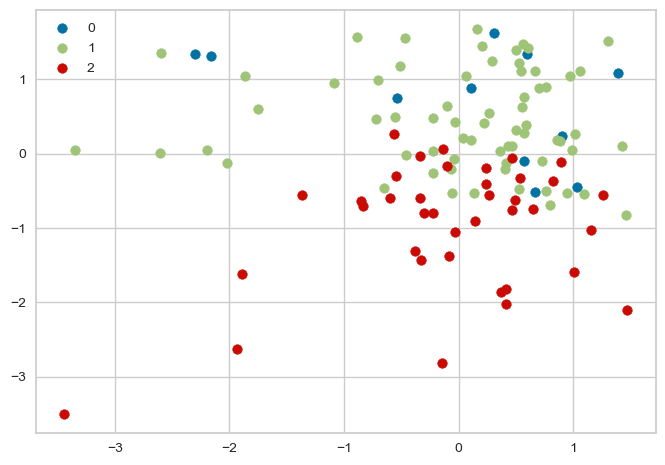

In [22]:
labels = np.unique(clusters)

for i in labels:
    plt.scatter(x_scaled[clusters == i , 0] , x_scaled[clusters == i , 1] , label = i)
plt.legend()
plt.show()

#### After trying with different n° of clusters, it is still difficult to make a call which number is the most suitable. It might be 2. I want to support this observation with a visualisation.

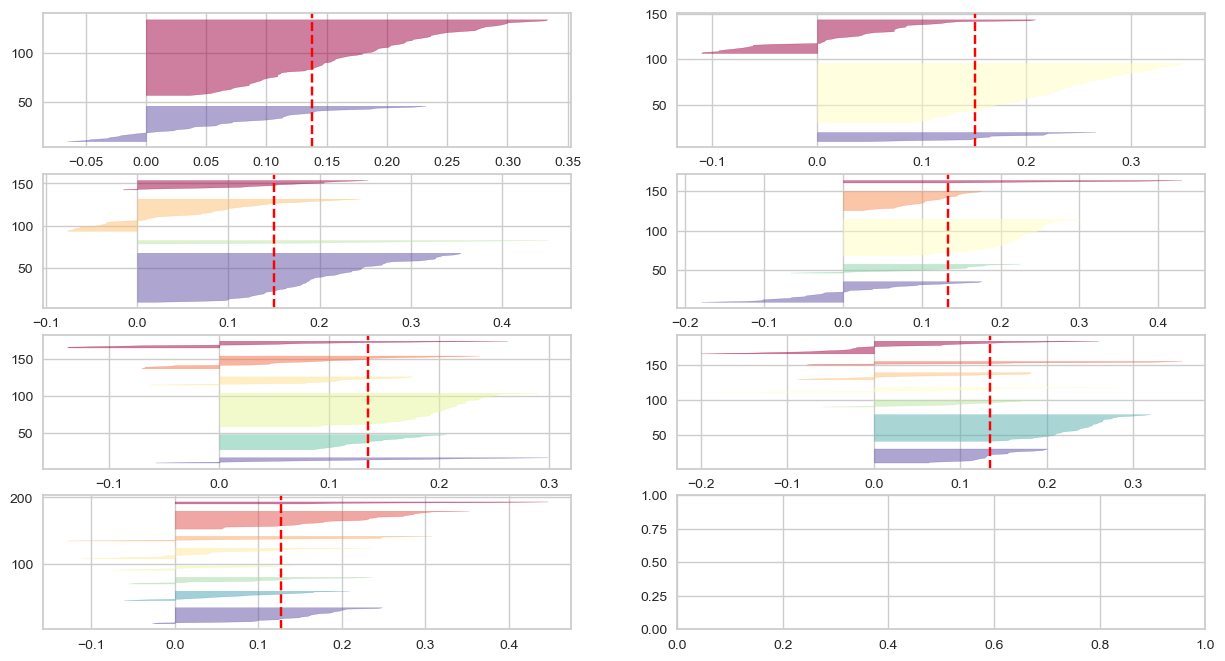

In [23]:
fig, ax = plt.subplots(4, 2, figsize=(15, 8))

k_values = range(2, 9)

for i, k in enumerate(k_values):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='Spectral_r', ax=ax[q, mod])
    visualizer.fit(x_scaled)

#### The difference in variation within one cluster is rather high independent from the number of clusters. But k = 2 is the highest, hence I discard it. k = 5 or k = 6 seem to be better fits. Let's explore further.

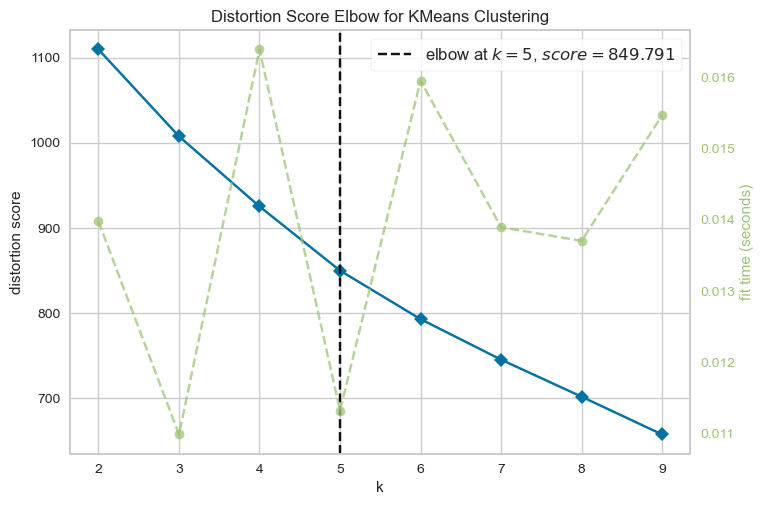

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(x_scaled)
visualizer.poof()

#### For both k = 5 and k = 6 there is a slight change in the direction of the line. A little elbow. Fitting time is the same. I choose 5 because it is recommended here and has less silhouette score plots split in minus and plus. 

It appears that assignation of clusters is somewhat difficult in this dataset, but I have to work with what I got.

In [25]:
km = KMeans(n_clusters=5, random_state=42)
km.fit(x_scaled)
clusters = km.predict(x_scaled)

# Getting a new dataframe with titles, artists, and clusters
songs_and_features_scaled = pd.DataFrame(x_scaled, columns=x.columns)
songs_and_features_scaled['song'] = songs_and_features_reset_index['song']
songs_and_features_scaled['artist'] = songs_and_features_reset_index['artist']
songs_and_features_scaled['cluster'] = clusters
songs_and_features_scaled.sample(1)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,song,artist,cluster
89,-0.146639,-2.817918,-0.643139,-0.64666,-0.7025,-0.504228,1.814764,-0.447336,-0.626059,-1.764452,-1.509949,Mi Viejo,Piero,0


In [26]:
def recommend_song():
    song_name = input('Choose a song with its artist: ')
    results = sp.search(q=f'track:{song_name}', limit=1)

    if len(results['tracks']['items']) == 0:
        print("Song not found, please check your input")
        return

    track_id = results['tracks']['items'][0]['id']
    audio_features = sp.audio_features(track_id)
    df = pd.DataFrame(audio_features)
    new_features = df[x.columns]
    x_scaled = scaler.transform(new_features)
    cluster = km.predict(x_scaled)
    filtered_df = songs_and_features_scaled[songs_and_features_scaled['cluster'] == cluster[0]][x.columns]
# To recommend any random song from the same cluster.
    #random_choice = random.choice(filtered_df.index)

    #print('\n [RECOMMENDED SONG]')
    #return ' - '.join([songs_and_features_scaled.loc[random_choice]['song'], songs_and_features_scaled.loc[random_choice]['artist']])

# To recommend the closest song from the dataset.   
    closest, _ = pairwise_distances_argmin_min(x_scaled, filtered_df)

    print('\n [RECOMMENDED SONG]')
    return ' - '.join([songs_and_features_scaled.loc[closest[0]]['song'], songs_and_features_scaled.loc[closest[0]]['artist']])

In [27]:
recommend_song()

Choose a song with its artist: FEEL - Davido

 [RECOMMENDED SONG]


'Al Gharam El Moustahil - Wael Kfoury'